### Use this script to plot the results

In [164]:
import json
import os
import shutil
import random
import numpy as np
from matplotlib import transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from tqdm import tqdm
import scipy.stats as ss


# Function to plot results
def plot_line_graph_var(
    subplot,
    print_curve_X_list, 
    print_curve_Y_list, 
    print_curve_name_list, 
    Title="", 
    XLabel="", 
    YLabel="", 
    X_MIN_MAX = None, 
    Y_MIN_MAX = None,
    AdditionalScore = None
    ):
    figure(figsize=(9, 6))
    
    print(print_curve_Y_list)
    if len(print_curve_X_list) > 6:
        cm = plt.get_cmap('gist_rainbow')
        is_rainbow = True
    else:
        cm = plt.get_cmap('tab10')
        is_rainbow = False
    NUM_COLORS = len(print_curve_X_list)
    custom_lines = []
    for i, (X, Y, curve_name) in enumerate(zip(print_curve_X_list, print_curve_Y_list, print_curve_name_list)):
        X = list(range(len(X)))
        try:
            Y_med = np.average(np.array(Y), axis=0)
            Y_max = np.max(np.array(Y), axis=0)
            Y_min = np.min(np.array(Y), axis=0)
            Y_std = np.std(np.array(Y), axis=0)/2
            if len(X) != len(Y_med):
                min_len = min(len(X), len(Y_med))
                X = X[:min_len]
                Y_med = Y_med[:min_len]
                Y_max = Y_max[:min_len]
                Y_min = Y_min[:min_len]
            # subplot.fill_between(X, Y_min, Y_max, color=cm(1.*i/NUM_COLORS), alpha=0.3)
            
            color = cm(1.*i/NUM_COLORS) if is_rainbow else cm(i)
            if curve_name == "Average":
                color = "black"
            custom_lines.append(Line2D([0], [0], color=color, lw=4))
            # Stdev
            # transform = matplotlib.transforms.Affine2D().translate(0, -0.01*(NUM_COLORS//2) + 0.01*i) + subplot.transData
            # Slightly shift X axis
            shift_base = X[0]/30
            shift_offset = 0 if NUM_COLORS %2 != 0 else shift_base/2
            shift_X = np.array(X) -shift_base*(NUM_COLORS//2) + shift_base*i + shift_offset
            if curve_name == "Average":
                subplot.plot(X, Y_med, marker='o', color=color) #linewidth=3
            else:
                subplot.plot(X, Y_med, marker='o', color=color, alpha=0.5, linestyle='dashed') #linewidth=3
        except Exception as e:
            print(f"Cannot plot {curve_name} due to the error: {e}")
    
    # if print_curve_name_list is not None:
    #     subplot.legend(custom_lines, print_curve_name_list)
    if X_MIN_MAX is not None or Y_MIN_MAX is not None:
        # ax = plt.gca()
        subplot.set_xlim(X_MIN_MAX)
        subplot.set_ylim(Y_MIN_MAX)
    # else:
    #     # ax = plt.gca()
    #     subplot.set_xlim([None, None])
    #     y_min = int(min(Y_min)//1)
    #     # print([y_min, y_min+8])
    #     subplot.set_ylim([y_min, y_min+12])
    
    subplot.set_xticks(list(range(len(print_curve_X_list[0])))) 
    subplot.set_xticklabels(print_curve_X_list[0], fontsize=16)
    subplot.tick_params(axis='y', labelsize=16)
    # subplot.set_title(Title, fontsize=24)
    # subplot.set_ylabel("AAAA", fontsize=24)
    # subplot.set_xlabel(XLabel, fontsize=24)
    return custom_lines, print_curve_name_list

def get_row_column(sub_fig_num):
    max_col_num = 3
    for i in range(1, 10):
        if i*max_col_num >= sub_fig_num:
            row = i
            break
    for i in range(1, 10):
        if i*row >= sub_fig_num:
            col=i
            break
    return row, col


def plot_line_graph_var_multiple(*args, savename = None):
    sub_fig_num = len(args)
    row, col = get_row_column(sub_fig_num)
    print(row, col)
    fig, axs = plt.subplots(
        row, 
        col, 
        figsize=(24, 5*row), 
        # layout="constrained",
        # sharey='row',
        # sharex=True,
    )
    print(len(axs))
    plt.style.use('seaborn-v0_8-darkgrid')
    # plt.setp(axs, xticks=[i for i in range(len(args[0][0]))], xticklabels=args[0][0])
    if row == 1:
        axs = [axs]
    if col == 1:
        axs = [[ax] for ax in axs]
    # Set Title
    
    axs[0][0].set_title("(a) Event Type Scaling", fontsize=28, y=1.1)
    axs[0][1].set_title("(b) Event Definition Scaling", fontsize=28, y=1.1)
    axs[0][2].set_title("(c) Sample Scaling", fontsize=28, y=1.1)
    # Set Y
    axs[0][0].set_ylabel("DivED -- Validation Set", fontsize=24)
    axs[1][0].set_ylabel("ACE -- Test Set", fontsize=24)
    # Set X
    axs[1][0].set_xlabel("# of Event", fontsize=24)
    axs[1][1].set_xlabel("# of Event Definition", fontsize=24)
    axs[1][2].set_xlabel("# of Sample", fontsize=24)
    # fig.tight_layout()
    fig.subplots_adjust(wspace=0.4)
    # plt.subplots_adjust(left = 0.2)
    # fig.tight_layout()
    # fig.supxlabel(args[0][4], fontsize = 24) # args[0][4] is X title
    fig.supylabel(args[0][5], fontsize = 24, x =0.07) # args[0][4] is Y title
    # print(args[0][4])
    for i in range(sub_fig_num):
        plot_args = [axs[i//col][i%col]]+args[i]
        if i == 2:
            axs[i//col][i%col].axis('off')
            continue
        custom_lines, print_curve_name_list = plot_line_graph_var(*plot_args, Y_MIN_MAX = [50, 80] if i < 3 else [15, 32])
        legend = fig.legend(custom_lines, print_curve_name_list, loc='lower center', ncol=len(custom_lines), columnspacing=2, bbox_to_anchor=(0.5,-0.07), fontsize=20, frameon=True, borderpad=0.8)
        legend.get_frame().set_alpha(1)
        legend.get_frame().set_facecolor("white")
        legend.get_frame().set_edgecolor("darkgray")
    # fig.tight_layout()
    plt.show()
    fig.savefig(savename, bbox_inches='tight')

2 3
2
[[[60.39, 63.91, 64.98, 65.23, 67.97, 75]], [[55.96, 57.45, 57.7, 59.51, 65.99, 67.81]], [[58.175, 60.68, 61.34, 62.370000000000005, 66.97999999999999, 71.405]]]
[[[53.71, 65.72, 67.38, 66.18, 65.23]], [[47.08, 56.74, 63.97, 59.37, 59.51]], [[50.394999999999996, 61.230000000000004, 65.675, 62.775000000000006, 62.370000000000005]]]
[[[17.68, 21.82, 24.54, 29.11, 23.23, 18.56]], [[17.46, 21.6, 20.95, 26.23, 21.46, 18.13]], [[17.57, 21.71, 22.744999999999997, 27.67, 22.345, 18.345]]]
[[[25.98, 28.72, 27.32, 29.66, 29.11]], [[22.92, 25.69, 24.81, 25.79, 26.23]], [[24.450000000000003, 27.205, 26.064999999999998, 27.725, 27.67]]]
[[[29.28, 28.48, 25.0, 22.29]], [[23.94, 26.17, 21.04, 17.26]], [[26.61, 27.325000000000003, 23.02, 19.775]]]


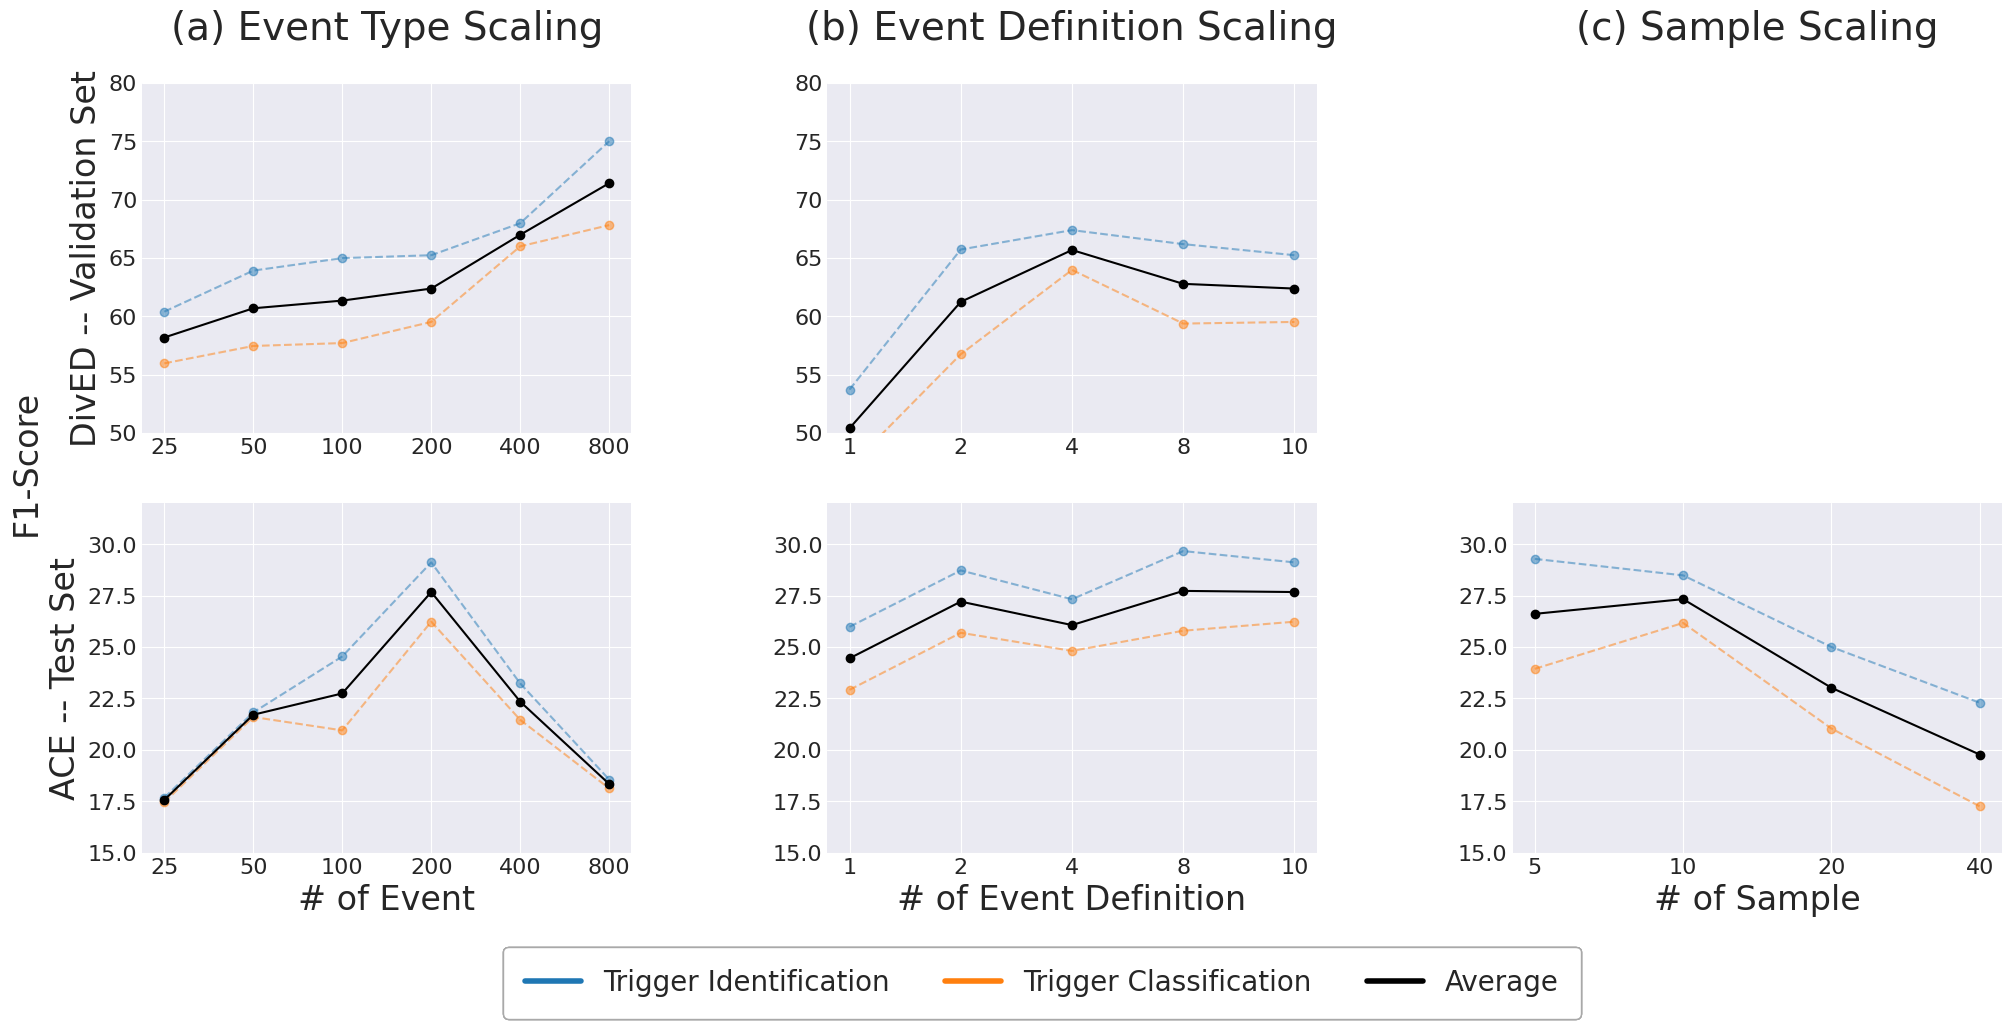

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [165]:
# Def Scale Scores
# Validation Set [subfig 0]
# ID, CLS
# Test Set  [subfig 1]
# ID, CLS

# Event Scale
# Event_X = [25, 50, 100, 200, 400, 800, 1600]
import numpy as np
Event_X = [25, 50, 100, 200, 400, 800]

Event_Y_list = [
    [
        [[60.39, 63.91, 64.98, 65.23, 67.97, 75]],
        [[55.96, 57.45, 57.7, 59.51, 65.99, 67.81]],
    ],
    [
        [[17.68, 21.82, 24.54, 29.11, 23.23, 18.56]],
        [[17.46, 21.6, 20.95, 26.23, 21.46, 18.13]],
    ]
]

Event_Y_list = [Y + [np.mean(Y, axis = 0).tolist()] for Y in Event_Y_list]
# Def Scale
Def_X = [1, 2, 4, 8, 10]

Def_Y_list = [
    [
        [[53.71, 65.72, 67.38, 66.18, 65.23]],
        [[47.08, 56.74, 63.97, 59.37, 59.51]],
    ],
    [
        [[25.98, 28.72, 27.32, 29.66, 29.11]],
        [[22.92, 25.69, 24.81, 25.79, 26.23]],
    ]
]
Def_Y_list = [Y + [np.mean(Y, axis = 0).tolist()] for Y in Def_Y_list]

# Sample Scale
Sample_X = [5, 10, 20, 40]

Sample_Y_list = [
    [
        [[-1, -1, -1, -1]],
        [[-1, -1, -1, -1]],
    ],
    [
        [[29.28, 28.48, 25.00, 22.29]],
        [[23.94, 26.17, 21.04, 17.26]],
    ]
]

Sample_Y_list = [Y + [np.mean(Y, axis = 0).tolist()] for Y in Sample_Y_list]

all_args = []
Legends = ["Trigger Identification", "Trigger Classification", "Average"]
# 0,0 - Event Scaling -- Val
all_args.append([
        [Event_X]*len(Event_Y_list[0]), #print_curve_X_list
        Event_Y_list[0], #print_curve_Y_list
        Legends, 
        "ACE -- Validation Set", # f"Scores of {metric}", #Title
        "Number of Event", #XLabel
        "F1-Score" #YLabel
    ])
# 0,1 - Def Scaling -- Val

all_args.append([
        [Def_X]*len(Def_Y_list[0]), #print_curve_X_list
        Def_Y_list[0], #print_curve_Y_list
        Legends,
        "ACE -- Validation Set", # f"Scores of {metric}", #Title
        "Number of Event Definition per Event Type", #XLabel
        "F1-Score" #YLabel
    ])
# 0,2 - Sample Scaling -- Val
all_args.append([
        [Sample_X]*len(Sample_Y_list[0]), #print_curve_X_list
        Sample_Y_list[0], #print_curve_Y_list
        Legends,
        "ACE -- Validation Set", # f"Scores of {metric}", #Title
        "Number of Sample per Event Type", #XLabel
        "F1-Score" #YLabel
    ])
# 1,0 - Event Scaling -- Test
all_args.append([
        [Event_X]*len(Event_Y_list[0]), #print_curve_X_list
        Event_Y_list[1], #print_curve_Y_list
        Legends,
        "ACE -- Test Set", # f"Scores of {metric}", #Title
        "Number of Event", #XLabel
        "F1-Score" #YLabel
    ])
# 1,1 - Def Scaling -- Test
all_args.append([
        [Def_X]*len(Def_Y_list[0]), #print_curve_X_list
        Def_Y_list[1], #print_curve_Y_list
        Legends,
        "ACE -- Test Set", # f"Scores of {metric}", #Title
        "Number of Event Definition per Event Type", #XLabel
        "F1-Score" #YLabel
    ])
# 1,2 - Sample Scaling -- Test
all_args.append([
        [Sample_X]*len(Sample_Y_list[0]), #print_curve_X_list
        Sample_Y_list[1], #print_curve_Y_list
        Legends,
        "ACE -- Test Set", # f"Scores of {metric}", #Title
        "Number of Sample per Event Type", #XLabel
        "F1-Score" #YLabel
    ])

plot_line_graph_var_multiple(
    *all_args, savename="ScalingLaw.pdf"
    )